In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.Plotting import add_subplot_index, save_figure
from tqdm import tqdm
import json
tqdm.pandas()

In [2]:
figure_folder = "Supplementary"

# Demographics and Comorbidities

In [3]:
# Load the variables
with open('./utils/variables.json', 'r') as file:
    variables = json.load(file)

SCR_feature_space = variables['SCR_feature_space']
LAB_feature_space = variables['LAB_feature_space']
train_len = variables['train_len']
test_len = variables['test_len']
start_date = variables['start_date']
split_date = variables['split_date']
end_date = variables['end_date']
print(len(SCR_feature_space), len(LAB_feature_space))
print(train_len, test_len)

7 40
8637 8542


In [4]:
internal_data = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/DEMO_KUMC.csv")
internal_data[["PATID", "ONSETS_ENCOUNTERID"]] = internal_data[["PATID", "ONSETS_ENCOUNTERID"]].astype(str)
external_test_set = pd.read_csv('/blue/yonghui.wu/lideyi/Personalization_Methodology/ext_test.csv')
external_test_set[["PATID", "ONSETS_ENCOUNTERID"]] = external_test_set[["PATID", "ONSETS_ENCOUNTERID"]].astype(str)
time_cols = ["ADMIT_DATE", "DISCHARGE_DATE", "PREDICTION_POINT"]

# Loop through the columns and convert to datetime
for col in time_cols:
    internal_data[col] = pd.to_datetime(internal_data[col])
    external_test_set[col] = pd.to_datetime(external_test_set[col])
    
print(len(internal_data), len(external_test_set))

17179 8542


In [5]:
# read the DX df
internal_DX_df = pd.read_csv('/blue/yonghui.wu/hoyinchan/Data/data2022raw/KUMC_ORCALE/raw/AKI_DX.csv', usecols = ['PATID', 'DX', 'DX_DATE"+PD.DATE_SHIFT"'])
external_DX_df = pd.read_csv('/blue/yonghui.wu/hoyinchan/Data/data2022raw/UPITT/raw/AKI_DX.csv', usecols = ['PATID', 'DX', 'DX_DATE'])

In [6]:
# format the dataframe
def format_DX_df(DX_df: pd.DataFrame) -> pd.DataFrame:
    DX_df.columns = ['PATID', 'DX_DATE', 'DX']
    DX_df[['PATID', 'DX']] = DX_df[['PATID', 'DX']].astype(str)
    DX_df['DX_DATE'] = pd.to_datetime(DX_df['DX_DATE'], format = 'mixed').dt.date
    DX_df.dropna(inplace = True)
    return DX_df

In [7]:
internal_DX_df = format_DX_df(internal_DX_df)
external_DX_df = format_DX_df(external_DX_df)

In [8]:
internal_dataset_DX_df = internal_data.merge(internal_DX_df, on='PATID', how='left')
# filter by admission date
internal_dataset_DX_df = internal_dataset_DX_df[internal_dataset_DX_df['DX_DATE'] < internal_dataset_DX_df['ADMIT_DATE']]
external_dataset_DX_df = external_test_set.merge(external_DX_df, on='PATID', how='left')
# filter by admission date
external_dataset_DX_df = external_dataset_DX_df[external_dataset_DX_df['DX_DATE'] < external_dataset_DX_df['ADMIT_DATE']]

In [9]:
def filter_by_DX(dataset_DX_df: pd.DataFrame) -> pd.DataFrame:
    # map the DX to disease
    dataset_DX_df.loc[:, 'DX_NAME'] = dataset_DX_df['DX'].progress_apply(map_to_disease)
    # delete the rows that cannot be mapped to any disease
    dataset_DX_df = dataset_DX_df.dropna(subset=['DX_NAME']).reset_index(drop=True)
    dataset_DX_df.drop('DX', axis=1, inplace=True)
    return dataset_DX_df

In [10]:
with open('./utils/DX_codes_combined.json', 'r') as json_file:
    DX_codes_combined = json.load(json_file)

In [11]:
def map_to_disease(DX):
    # DX_codes here is a global variable
    for disease, codes in DX_codes_combined.items():
        if any(DX.startswith(code) for code in codes):
            return disease
    return None

In [12]:
internal_dataset_DX_df = filter_by_DX(internal_dataset_DX_df)
external_dataset_DX_df = filter_by_DX(external_dataset_DX_df)

100%|██████████| 402688/402688 [00:15<00:00, 26443.40it/s]


In [13]:
def pivot_DX_df(dataset_DX_df: pd.DataFrame) -> pd.DataFrame:
    # pivot onset_DX_df to get the diagnosis feature, values as binary, index as pat_id_cols and columns as DX
    DX_feature_pivot = dataset_DX_df.pivot_table(index=["PATID", "ONSETS_ENCOUNTERID"], 
                                                 columns='DX_NAME', aggfunc='size', fill_value=0)
    # Convert the pivot table to binary (1 if the patient had the diagnose, 0 otherwise)
    DX_feature_pivot = (DX_feature_pivot > 0).astype(int)
    # Reset the index to make it a regular dataframe
    DX_feature_pivot.reset_index(inplace=True)
    return DX_feature_pivot

In [14]:
internal_DX_feature_pivot = pivot_DX_df(internal_dataset_DX_df)
external_DX_feature_pivot = pivot_DX_df(external_dataset_DX_df)

In [15]:
# Get common columns
DX_common_cols = internal_DX_feature_pivot.columns.intersection(external_DX_feature_pivot.columns)
internal_DX_feature_pivot = internal_DX_feature_pivot[DX_common_cols].copy(deep = True)
external_DX_feature_pivot = external_DX_feature_pivot[DX_common_cols].copy(deep = True)
# remove ID cols
DX_common_cols = DX_common_cols[2:]

In [16]:
internal_data = internal_data.merge(internal_DX_feature_pivot, on = ["PATID", "ONSETS_ENCOUNTERID"], how='left')
internal_data.loc[:, DX_common_cols] = internal_data[DX_common_cols].fillna(0)
external_test_set = external_test_set.merge(external_DX_feature_pivot, on = ["PATID", "ONSETS_ENCOUNTERID"], how='left')
external_test_set.loc[:, DX_common_cols] = external_test_set[DX_common_cols].fillna(0)
print(len(internal_data), len(external_test_set))

17179 8542


In [17]:
# read demographics
internal_DEMO_df = pd.read_csv("/blue/yonghui.wu/hoyinchan/Data/data2022raw/KUMC_ORCALE/raw/AKI_DEMO.csv", 
                      delimiter = ',', usecols = ['ONSETS_ENCOUNTERID', 'AGE', 'PATID', 'SEX', 'RACE'])
external_DEMO_df = pd.read_csv("/blue/yonghui.wu/hoyinchan/Data/data2022raw/UPITT/raw/AKI_DEMO.csv", 
                      delimiter = ',', usecols = ['ONSETS_ENCOUNTERID', 'AGE', 'PATID', 'SEX', 'RACE'])

In [18]:
# format the df
internal_DEMO_df[['PATID', 'ONSETS_ENCOUNTERID', 'SEX', 'RACE']] = internal_DEMO_df[['PATID', 'ONSETS_ENCOUNTERID', 'SEX', 'RACE']].astype(str)
external_DEMO_df[['PATID', 'ONSETS_ENCOUNTERID', 'SEX', 'RACE']] = external_DEMO_df[['PATID', 'ONSETS_ENCOUNTERID', 'SEX', 'RACE']].astype(str)
internal_DEMO_df = internal_DEMO_df.drop_duplicates(subset=["PATID", "ONSETS_ENCOUNTERID"]).reset_index(drop=True)
external_DEMO_df = external_DEMO_df.drop_duplicates(subset=["PATID", "ONSETS_ENCOUNTERID"]).reset_index(drop=True)

In [19]:
internal_data = internal_data.merge(internal_DEMO_df, on = ['PATID', 'ONSETS_ENCOUNTERID'], how = "left")
external_test_set = external_test_set.merge(external_DEMO_df, on = ['PATID', 'ONSETS_ENCOUNTERID'], how = "left")

In [20]:
patient_pool = internal_data.iloc[:train_len, :].copy(deep = True)
internal_test_set = internal_data.iloc[train_len:, :].copy(deep = True)

# Fill in Cohort Information Table

In [21]:
from datetime import datetime, timedelta

In [22]:
demo_info = pd.DataFrame("", index = ["Source", "Cohort size", "Time window", "Number of lab features", 
                                      "SCr trajectory days", "Averaged SCr levels 48h prior to the prediction points (mg/dL)",
                                      "AKI rates (%)", "Male (%)", "Black race (%)", "Age ≥ 70 (%)"], 
                         columns = ["Patient pool", "Internal test set", "External test set"])

In [23]:
demo_info.loc["Source", "Patient pool"] = "KUMC"
demo_info.loc["Source", "Internal test set"] = "KUMC"
demo_info.loc["Source", "External test set"] = "UPMC"

demo_info.loc["Cohort size", "Patient pool"] = len(patient_pool)
demo_info.loc["Cohort size", "Internal test set"] = len(internal_test_set)
demo_info.loc["Cohort size", "External test set"] = len(external_test_set)

demo_info.loc["SCr trajectory days", ["Patient pool", "Internal test set", "External test set"]] = len(SCR_feature_space)

In [24]:
def minus_one_day(date: str) -> str:
    # Convert string to datetime object
    date_obj = datetime.strptime(date, '%Y-%m-%d')

    # Subtract one day
    new_date_obj = date_obj - timedelta(days=1)

    # Convert back to string
    new_date_str = new_date_obj.strftime('%Y-%m-%d')
    return new_date_str

In [25]:
demo_info.loc["Time window", "Patient pool"] = "%s ~ %s"%(start_date, minus_one_day(split_date))
demo_info.loc["Time window", "Internal test set"] = "%s ~ %s"%(split_date, minus_one_day(end_date))
demo_info.loc["Time window", "External test set"] = "%s ~ %s"%(split_date, minus_one_day(end_date))

demo_info.loc["AKI rates (%)", "Patient pool"] = f"{patient_pool.AKI_LABEL.mean() * 100:.2f}"
demo_info.loc["AKI rates (%)", "Internal test set"] = f"{internal_test_set.AKI_LABEL.mean() * 100:.2f}"
demo_info.loc["AKI rates (%)", "External test set"] = f"{external_test_set.AKI_LABEL.mean() * 100:.2f}"

demo_info.loc["Averaged SCr levels 48h prior to the prediction points (mg/dL)", 'Patient pool'] = f"{patient_pool['-2'].mean():.2f} ({patient_pool['-2'].std():.2f})"
demo_info.loc["Averaged SCr levels 48h prior to the prediction points (mg/dL)", 'Internal test set'] = f"{internal_test_set['-2'].mean():.2f} ({internal_test_set['-2'].std():.2f})"
demo_info.loc["Averaged SCr levels 48h prior to the prediction points (mg/dL)", 'External test set'] = f"{external_test_set['-2'].mean():.2f} ({external_test_set['-2'].std():.2f})"

demo_info.loc["Number of lab features", ["Patient pool", "Internal test set", "External test set"]] = len(LAB_feature_space)

demo_info.loc["Male (%)", 'Patient pool'] = f"{(patient_pool['SEX'] == "M").mean() * 100:.2f}"
demo_info.loc["Male (%)", 'Internal test set'] = f"{(internal_test_set['SEX'] == "M").mean() * 100:.2f}"
demo_info.loc["Male (%)", 'External test set'] = f"{(external_test_set['SEX'] == "M").mean() * 100:.2f}"

demo_info.loc["Black race (%)", 'Patient pool'] = f"{(patient_pool['RACE'] == "03").mean() * 100:.2f}"
demo_info.loc["Black race (%)", 'Internal test set'] = f"{(internal_test_set['RACE'] == "03").mean() * 100:.2f}"
demo_info.loc["Black race (%)", 'External test set'] = f"{(external_test_set['RACE'] == "03").mean() * 100:.2f}"

demo_info.loc["Age ≥ 70 (%)", 'Patient pool'] = f"{(patient_pool['AGE'] >= 70).mean() * 100:.2f}"
demo_info.loc["Age ≥ 70 (%)", 'Internal test set'] = f"{(internal_test_set['AGE'] >= 70).mean() * 100:.2f}"
demo_info.loc["Age ≥ 70 (%)", 'External test set'] = f"{(external_test_set['AGE'] >= 70).mean() * 100:.2f}"

for DX in DX_common_cols:
    DX_index = DX.replace("_", " ").capitalize() + " (%)"
    demo_info.loc[DX_index, 'Patient pool'] = f"{(patient_pool[DX] == 1).mean() * 100:.2f}"
    demo_info.loc[DX_index, 'Internal test set'] = f"{(internal_test_set[DX] == 1).mean() * 100:.2f}"
    demo_info.loc[DX_index, 'External test set'] = f"{(external_test_set[DX] == 1).mean() * 100:.2f}"

In [26]:
# add p values
from scipy.stats import chi2_contingency

In [27]:
def select_p_vals(p: float) -> str:
    if p < 0.001:
        return '<0.001'
    elif p < 0.01:
        return '<0.01'
    elif p < 0.05:
        return '<0.05'
    else:
        return 'NS'

In [28]:
n_rows_skip = 6
cohort_sizes = np.array(demo_info.loc['Cohort size'].astype(int))
# Initialize a list to store p-values
p_values = []

for row in demo_info.index[n_rows_skip:]:
    # Convert percentages to counts using cohort sizes
    DX_pcts = demo_info.loc[row].astype(float) / 100
    counts = np.array((DX_pcts * cohort_sizes).round().astype(int))
    
    # Create a contingency table for chi-squared test
    contingency_table = np.array([counts, cohort_sizes - counts])

    # Perform chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_values.append(select_p_vals(p))

    # Add the p-values as a new column to the DataFrame
demo_info['P values'] = ["/"] * n_rows_skip + p_values  # First row is None, rest are p-values

In [29]:
demo_info

,Patient pool,Internal test set,External test set,P values
Source,KUMC,KUMC,UPMC,/
Cohort size,8637,8542,8542,/
Time window,2015-01-01 ~ 2015-12-31,2016-01-01 ~ 2016-12-31,2016-01-01 ~ 2016-12-31,/
Number of lab features,40,40,40,/
SCr trajectory days,7,7,7,/
Averaged SCr levels 48h prior to the prediction points (mg/dL),0.87 (0.36),0.86 (0.35),0.94 (0.42),/
AKI rates (%),8.07,7.98,7.86,NS
Male (%),51.33,51.88,48.28,<0.001
Black race (%),13.33,12.71,9.55,<0.001
Age ≥ 70 (%),28.27,29.43,45.15,<0.001


In [30]:
demo_info.to_csv("./High_res_figures/cohort_information.csv", index = True)

# Plot Grid Seach Table

In [31]:
grid_search_table = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput2_LR.csv",
                               index_col = 0)

In [32]:
def plot_measure_count(ax, condition: str, grid_search_table: pd.DataFrame, title: str) -> None:
    count = dict(grid_search_table[condition].value_counts())
    
    if condition.startswith("SCR"):
        full_name = ["DTW", "Euc", "Cos", "Manh"]
        for name in full_name:
            if name not in list(count.keys()):
                count[name] = 0
    else:
        full_name = ["Euc", "Cos", "Manh"]
        for name in full_name:
            if name not in list(count.keys()):
                count[name] = 0
                
    ax.barh(list(count.keys())[::-1], list(count.values())[::-1], color= ['blue'] * (len(count) - 1) + ['orange'])
    
    
    ax.set_xlabel('Counts')
    ax.set_ylabel('Distance measure')
    ax.set_title(title)

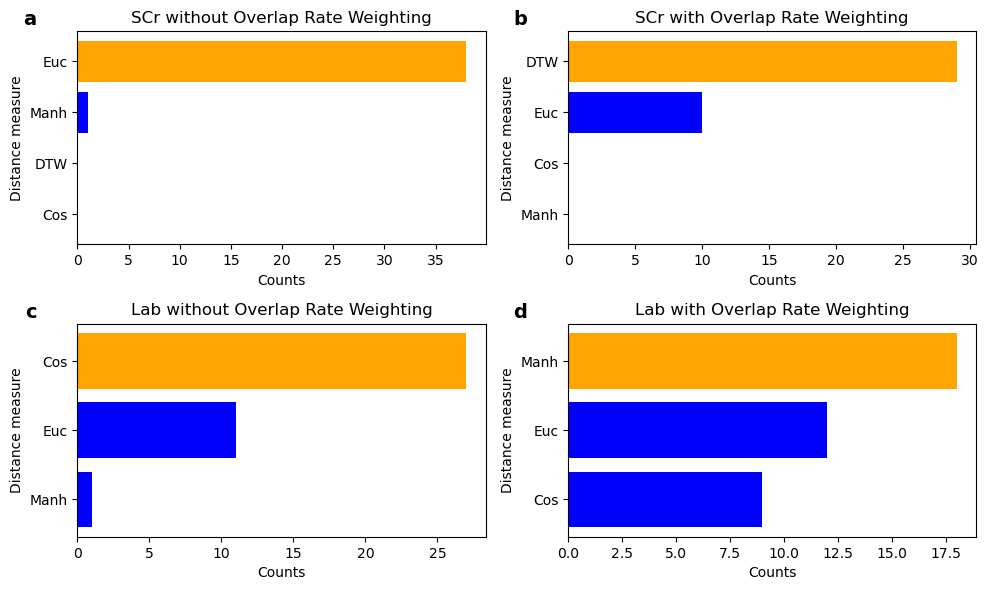

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Supplementary/Distance-measure-counts.tif


In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6)) 
plot_measure_count(axs[0, 0], "SCR NW", grid_search_table, "SCr without Overlap Rate Weighting")
plot_measure_count(axs[0, 1], "SCR WT", grid_search_table, "SCr with Overlap Rate Weighting")
plot_measure_count(axs[1, 0], "LAB NW", grid_search_table, "Lab without Overlap Rate Weighting")
plot_measure_count(axs[1, 1], "LAB WT", grid_search_table, "Lab with Overlap Rate Weighting")
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "Distance-measure-counts")

In [34]:
vanilla_SCR_weights = list(eval(combo)[0] for combo in grid_search_table["COMBINE NW"])
vanilla_LAB_weights = list(eval(combo)[1] for combo in grid_search_table["COMBINE NW"])
OW_SCR_weights = list(eval(combo)[0] for combo in grid_search_table["COMBINE WT"])
OW_LAB_weights = list(eval(combo)[1] for combo in grid_search_table["COMBINE WT"])

In [35]:
from matplotlib.lines import Line2D
k_sizes_train = [i for i in range(10, 201, 5)]

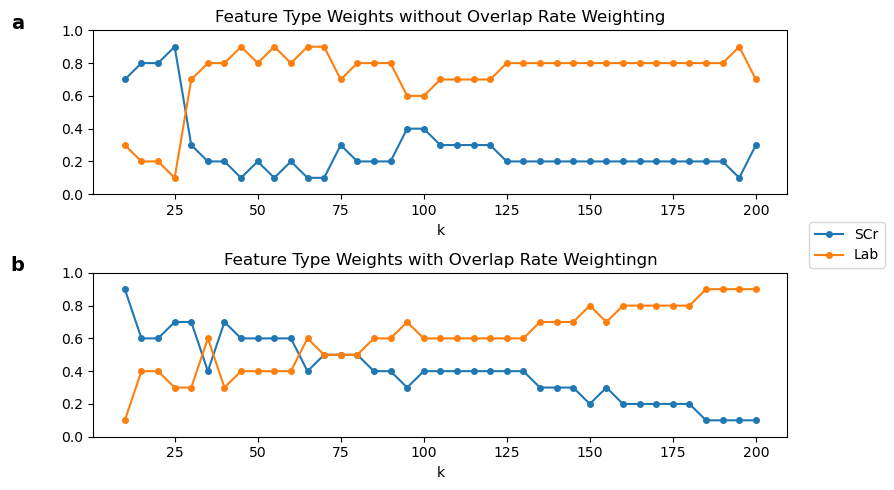

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Supplementary/Feature-type-weighting.tif


In [36]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5)) 
axs[0].plot(k_sizes_train, vanilla_SCR_weights, marker='o', markersize = 4)
axs[0].plot(k_sizes_train, vanilla_LAB_weights, marker='o', markersize = 4)
axs[1].plot(k_sizes_train, OW_SCR_weights, marker='o', markersize = 4)
axs[1].plot(k_sizes_train, OW_LAB_weights, marker='o', markersize = 4)
axs[0].set_ylim(0, 1)
axs[1].set_ylim(0, 1)
axs[0].set_xlabel("k")
axs[1].set_xlabel("k")

axs[0].set_title("Feature Type Weights without Overlap Rate Weighting")
axs[1].set_title("Feature Type Weights with Overlap Rate Weightingn")

lines = [Line2D([0], [0], color='C0', marker='o', markersize=4, linestyle='-', label='SCr'),
         Line2D([0], [0], color='C1', marker='o', markersize=4, linestyle='-', label='Lab')]

fig.legend(handles=lines, loc='center left', bbox_to_anchor=(1, 0.5))
add_subplot_index(axs, 2, 1)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "Feature-type-weighting")

# Plot Overlap Rate Matrix Heatmap

In [37]:
import json

In [38]:
#data overlap rate (entire dataset)
SCR_overlap_internal = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap.npy')
LAB_overlap_internal = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap.npy')
SCR_overlap_external = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap_external.npy')
LAB_overlap_external = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap_external.npy')

In [39]:
SCR_internal_train = SCR_overlap_internal[:train_len, :train_len]
SCR_internal_test_to_train = SCR_overlap_internal[train_len:, :train_len]
SCR_external_test_to_train = SCR_overlap_external[train_len:, :train_len]

LAB_internal_train = LAB_overlap_internal[:train_len, :train_len]
LAB_internal_test_to_train = LAB_overlap_internal[train_len:, :train_len]
LAB_external_test_to_train = LAB_overlap_external[train_len:, :train_len]

In [40]:
def plot_matrix_dist(ax, mtx, title):
    array_1d = mtx.flatten()

    bins = np.arange(0, 1.01, 0.01)
    hist, bin_edges, patches = ax.hist(array_1d, bins=bins, edgecolor='none', alpha=0.6, color = "black")
    
    median_val = np.median(array_1d)
    
    for i in range(len(bin_edges) - 1):
        if bin_edges[i] <= median_val < bin_edges[i + 1]:
            patches[i].set_facecolor('red')
            break

    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(title)

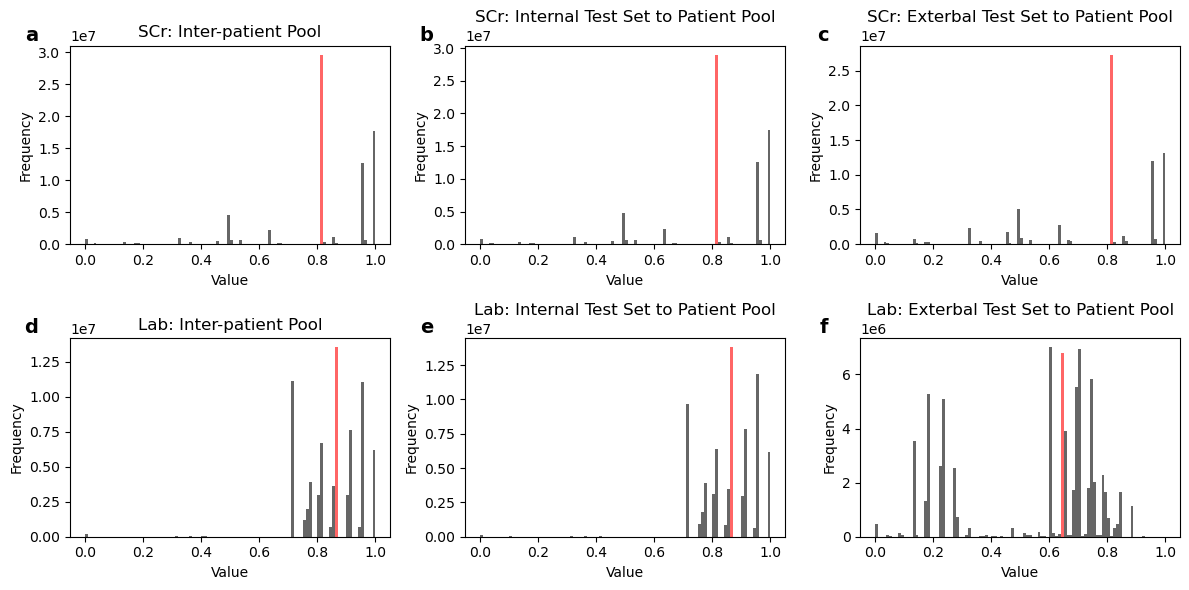

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Supplementary/Overlap-rates-distribution.tif


In [41]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6)) 
# SCR
plot_matrix_dist(axs[0, 0], SCR_internal_train, "SCr: Inter-patient Pool")
plot_matrix_dist(axs[0, 1], SCR_internal_test_to_train, "SCr: Internal Test Set to Patient Pool")
plot_matrix_dist(axs[0, 2], SCR_external_test_to_train, "SCr: Exterbal Test Set to Patient Pool")
# Lab
plot_matrix_dist(axs[1, 0], LAB_internal_train, "Lab: Inter-patient Pool")
plot_matrix_dist(axs[1, 1], LAB_internal_test_to_train, "Lab: Internal Test Set to Patient Pool")
plot_matrix_dist(axs[1, 2], LAB_external_test_to_train, "Lab: Exterbal Test Set to Patient Pool")
add_subplot_index(axs, 2, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "Overlap-rates-distribution")

In [42]:
def plot_data_missing_rates(ax, df, col_names, title, ylabel, sort = False):
    nan_rate = df[col_names].isna().mean()
    
    if sort:
        nan_rate = nan_rate.sort_values(ascending=True)

    ax.barh(nan_rate.index, nan_rate.values, color='skyblue')
    ax.set_xlabel('Data Missing Rate')
    ax.set_ylabel(ylabel)
    ax.set_title(title)

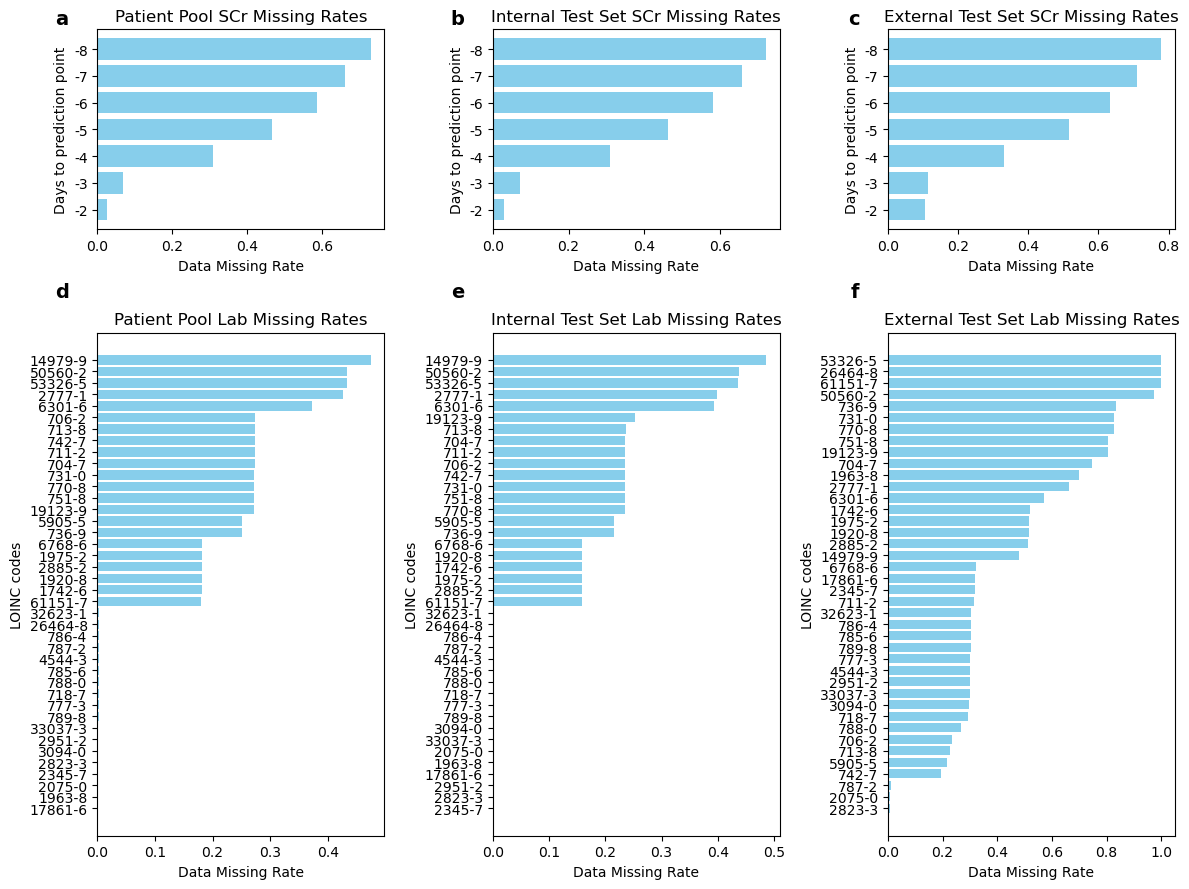

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Supplementary/Feature-raw-missing-rates.tif


In [43]:
from matplotlib.gridspec import GridSpec

# Create the figure and gridspec
fig = plt.figure(figsize=(12, 9))
gs = GridSpec(3, 3, figure=fig) 
# Plot the 2x2 grid (SCR-LR plots)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), 
       fig.add_subplot(gs[1:3, 0]), fig.add_subplot(gs[1:3, 1]), fig.add_subplot(gs[1:3, 2])]


plot_data_missing_rates(axs[0], patient_pool, SCR_feature_space[::-1], "Patient Pool SCr Missing Rates", "Days to prediction point")
plot_data_missing_rates(axs[1], internal_test_set, SCR_feature_space[::-1], "Internal Test Set SCr Missing Rates", "Days to prediction point")
plot_data_missing_rates(axs[2], external_test_set, SCR_feature_space[::-1], "External Test Set SCr Missing Rates", "Days to prediction point")
plot_data_missing_rates(axs[3], patient_pool, LAB_feature_space, "Patient Pool Lab Missing Rates", "LOINC codes", True)
plot_data_missing_rates(axs[4], internal_test_set, LAB_feature_space, "Internal Test Set Lab Missing Rates", "LOINC codes", True)
plot_data_missing_rates(axs[5], external_test_set, LAB_feature_space, "External Test Set Lab Missing Rates", "LOINC codes", True)

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

for ax, label in zip(axs, labels):
    # Add text label at the top-left corner of each subplot
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=14, 
            fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "Feature-raw-missing-rates")